In [1]:
import torch

In [2]:
torch.__version__

'2.1.1+cu121'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
import os

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
from torch.nn import Module
from torch.nn import TransformerEncoderLayer
from torch.nn import TransformerEncoder
from torch.nn import TransformerDecoderLayer
from torch.nn import TransformerDecoder
from torch.nn import LayerNorm
from torch.nn import BatchNorm1d
from torch.nn import Linear

from torch import optim
from torch.optim import Adam
from torch.nn import functional as F
from torch.nn.functional import mse_loss

import torch.utils.data as Data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from tqdm import tqdm

In [7]:
df = pd.read_csv("./preprocessed-data/krwvnd.csv", index_col="Date")
df.head()

,Close
Date,
2004-01-02,12.661377
2004-01-05,12.597076
2004-01-06,12.724485
2004-01-07,12.622449
2004-01-08,12.665998


In [8]:
def get_date(x): 
    return pd.to_datetime(x).date()

In [9]:
df.index = df.index.map(lambda x: get_date(x))

In [10]:
df.index

Index([2004-01-02, 2004-01-05, 2004-01-06, 2004-01-07, 2004-01-08, 2004-01-09,
       2004-01-12, 2004-01-13, 2004-01-14, 2004-01-15,
       ...
       2023-10-22, 2023-10-23, 2023-10-24, 2023-10-25, 2023-10-26, 2023-10-27,
       2023-10-28, 2023-10-29, 2023-10-30, 2023-10-31],
      dtype='object', name='Date', length=5979)

In [11]:
def min_max_normalization(x, min, max):
    return (x - min) / (max - min)

In [12]:
def get_feat(x):
    return [min_max_normalization(x.year, 2004, 2023), min_max_normalization(x.month, 1, 12), min_max_normalization(x.day, 1, 31)]

In [13]:
def get_features(data, _from, _to):
    return [get_feat(x) for x in data.iloc[_from:_to].index]
    return data.iloc[_from:_to].index.map(lambda x: [get_date(x).year, get_date(x).month, get_date(x).day]).to_list()

In [14]:
def get_values(data, _from, _to):
    return data.iloc[_from:_to].Close.to_list()

In [15]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

# Initializing a Time Series Transformer configuration with 30 time steps for prediction
configuration = TimeSeriesTransformerConfig(context_length=96, 
                                            prediction_length=30,
                                            num_time_features=3
                                            # num_static_categorical_features=64,
                                            # num_static_real_features=64,
                                            )

# Randomly initializing a model (with random weights) from the configuration
model = TimeSeriesTransformerForPrediction(configuration).to(device)

# Accessing the model configuration
configuration = model.config

In [16]:
# refered: https://pseudo-lab.github.io/Tutorial-Book/chapters/time-series/Ch3-preprocessing.html
def create_sequences(data, context_len, prediction_len):
    batch_data = []
    for i in tqdm(range(len(data)-context_len-prediction_len+1)):
        x = get_values(data, i, i+context_len)
        y = get_values(data, i+context_len, i+context_len+prediction_len)

        x_feat = get_features(data, i, i+context_len)
        y_feat = get_features(data, i+context_len, i+context_len+prediction_len)
        batch_data.append({
            "past_values": torch.Tensor(x).type(torch.FloatTensor),
            "future_values": torch.Tensor(y).type(torch.FloatTensor),
            "past_time_features": torch.Tensor(x_feat).type(torch.FloatTensor),
            "future_time_features": torch.Tensor(y_feat).type(torch.FloatTensor),
            "past_observed_mask": torch.Tensor(np.ones(context_len, dtype=bool)).type(torch.BoolTensor),
            "future_observed_mask": torch.Tensor(np.ones(context_len, dtype=bool)).type(torch.BoolTensor),
        })

    return batch_data

In [17]:
class CustomDataset(Dataset):
    def __init__(self, mode="train", context_len=96, prediction_len=12):
        df = pd.read_csv("./preprocessed-data/krwvnd.csv", index_col="Date")
        df.index = df.index.map(lambda x: get_date(x))
        df["Close"] = df["Close"].map(lambda x: float(x))
        df = df.div(df.iloc[0])

        train_size = int(len(df) * 0.8)

        if mode == "train":
            self.data = create_sequences(df[:train_size], context_len+max(configuration.lags_sequence), prediction_len)
        elif mode == "valid":
            self.data = create_sequences(df[train_size:], context_len+max(configuration.lags_sequence), prediction_len)
        # else:

        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [18]:
EPOCH = 100
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
MODEL_PATH = "./models"

In [19]:
dataset = CustomDataset(mode="train", context_len=96, prediction_len=30)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
dataset = CustomDataset(mode="valid", context_len=96, prediction_len=30)
valid_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 1064/1064 [00:00<00:00, 1676.86it/s]


In [20]:
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

In [21]:
sum(p.numel() for p in model.parameters())

136003

In [92]:
# Prepare loss history
hist_loss = np.zeros(EPOCH)
hist_loss_val = np.zeros(EPOCH)

# Record the best model
valid_loss_best = np.inf

for epoch in range(EPOCH):
    train_loss = 0
    valid_loss = 0
    model.train()
    with tqdm(total=len(train_loader), desc=f"[Epoch {epoch+1:3d}/{EPOCH}]") as pbar:
        for idx, batch in enumerate(train_loader):
            outputs = model(
                past_values=batch["past_values"].to(device),
                past_time_features=batch["past_time_features"].to(device),
                future_values=batch["future_values"].to(device),
                future_time_features=batch["future_time_features"].to(device),
                past_observed_mask=batch["past_observed_mask"].to(device),
                # future_observed_mask=batch["future_observed_mask"],
            )
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().item()

            pbar.set_postfix({'train_loss': train_loss/(idx+1)})
            pbar.update(1)

        model.eval()
        with torch.no_grad():
            for idx, batch in enumerate(valid_loader):
                outputs = model(
                    past_values=batch["past_values"].to(device),
                    past_time_features=batch["past_time_features"].to(device),
                    future_values=batch["future_values"].to(device),
                    future_time_features=batch["future_time_features"].to(device),
                    past_observed_mask=batch["past_observed_mask"].to(device),
                )
                loss = outputs.loss
                valid_loss += loss.detach().cpu().item()
                pbar.set_postfix({'valid_loss': valid_loss/(idx+1)})

        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)
        pbar.set_postfix({'train_loss': train_loss, 'valid_loss': valid_loss})

        hist_loss[epoch] = train_loss
        hist_loss_val[epoch] = valid_loss

        if valid_loss < valid_loss_best:
            valid_loss_best = valid_loss
            torch.save(model.state_dict(), os.path.join(MODEL_PATH, f"epoch-{epoch}"))
    

[Epoch 100/100]: 100%|██████████| 19/19 [00:10<00:00,  1.89it/s, train_loss=-1.94, valid_loss=-2.1]


model exported to ./models with loss -2.133860


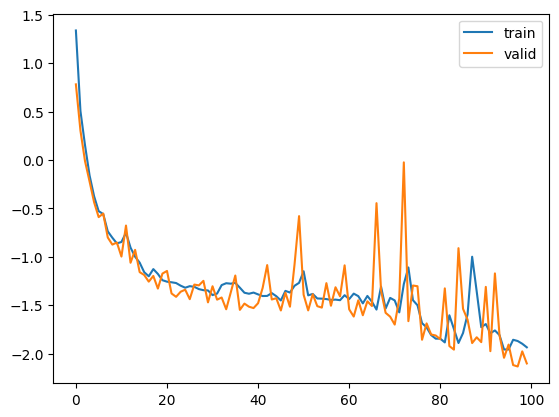

In [93]:
plt.plot(hist_loss, label='train')
plt.plot(hist_loss_val, label='valid')
plt.legend()
print(f"model exported to {MODEL_PATH} with loss {valid_loss_best:6f}")

In [31]:
def denormalize(x):
    return x * scale

In [95]:
model.eval()
with torch.no_grad():
    avg_mse = 0
    NUM_LOOP = 100
    with tqdm(total=NUM_LOOP) as pbar:
        for _ in range(NUM_LOOP):
            mse_valid = 0
            for idx, batch in enumerate(valid_loader):
                outputs = model.generate(
                    past_values=batch["past_values"][0].unsqueeze(0).to(device),
                    past_time_features=batch["past_time_features"][0].unsqueeze(0).to(device),
                    # future_values=batch["future_values"][0].unsqueeze(0).to(device),
                    future_time_features=batch["future_time_features"][0].unsqueeze(0).to(device),
                    past_observed_mask=batch["past_observed_mask"][0].unsqueeze(0).to(device),
                    # num_beams=1,
                )

                prediction = denormalize(outputs.sequences.mean(dim=1).to(device))
                ground_truth = denormalize(batch['future_values'][0].unsqueeze(0).to(device))

                mse_valid += mse_loss(prediction, ground_truth).cpu().item()
            
            avg_mse += mse_valid
            pbar.set_postfix({'Avg_MSE': avg_mse/(_+1)})
            pbar.update(1)

    print(f"MSE Loss: {avg_mse/(NUM_LOOP)}")

    # plt.plot(prediction.squeeze(0).detach().cpu().numpy(), color="orange")
    # plt.plot(ground_truth.squeeze(0).detach().cpu().numpy(), color="green")
    # plt.show()

100%|██████████| 100/100 [04:57<00:00,  2.98s/it, Avg_MSE=0.00722]

MSE Loss: 0.00721742444911797


In [22]:
df = pd.read_csv("./preprocessed-data/krwvnd.csv", index_col="Date")
df.index = df.index.map(lambda x: get_date(x))
df["Close"] = df["Close"].map(lambda x: float(x))
scale = df.iloc[0].values[0]
df = df.div(df.iloc[0])

In [23]:
df

,Close
Date,
2004-01-02,1.000000
2004-01-05,0.994921
2004-01-06,1.004984
2004-01-07,0.996925
2004-01-08,1.000365
...,...
2023-10-27,1.431432
2023-10-28,1.431380
2023-10-29,1.431380


In [24]:
df[-96-7:]

,Close
Date,
2023-07-21,1.452204
2023-07-22,1.452204
2023-07-23,1.452204
2023-07-24,1.459824
2023-07-25,1.466489
...,...
2023-10-27,1.431432
2023-10-28,1.431380
2023-10-29,1.431380


In [25]:
test_df = pd.read_csv("./krwvnd-test.csv")
test_df["Close"] = test_df.Close.map(lambda x: np.float32(x.replace(",", ".")))
test_df["Date"] = test_df.Date.map(lambda x: pd.to_datetime(x, dayfirst=True).date())
test_df["Close"] = test_df["Close"] / scale
test_df = test_df.set_index("Date")
test_df.head()

,Close
Date,
2023-11-01,1.439997
2023-11-02,1.454784
2023-11-03,1.480337
2023-11-04,1.480162
2023-11-05,1.480162


In [26]:
data = pd.concat([df[-96-7:], test_df])
data
# create_sequences(df[:train_size], context_len+max(configuration.lags_sequence), prediction_len)

,Close
Date,
2023-07-21,1.452204
2023-07-22,1.452204
2023-07-23,1.452204
2023-07-24,1.459824
2023-07-25,1.466489
...,...
2023-11-26,1.467583
2023-11-27,1.467569
2023-11-28,1.472464


In [27]:
inp = create_sequences(data, 96+max(configuration.lags_sequence), 30)

100%|██████████| 1/1 [00:00<00:00, 558.79it/s]


In [84]:
model.load_state_dict(torch.load(f"{MODEL_PATH}/epoch-94"))

<All keys matched successfully>

In [85]:
model.eval()
with torch.no_grad():
    outputs = model.generate(
        past_values=inp[0]["past_values"].unsqueeze(0).to(device),
        past_time_features=inp[0]["past_time_features"].unsqueeze(0).to(device),
        # future_values=inp[0]["future_values"].unsqueeze(0).to(device),
        future_time_features=inp[0]["future_time_features"].unsqueeze(0).to(device),
        past_observed_mask=inp[0]["past_observed_mask"].unsqueeze(0).to(device),
        # num_beams=1,
    )
    # print(outputs.sequences.mean(dim=1).squeeze(0).cpu())
    prediction = denormalize(outputs.sequences.mean(dim=1).squeeze(0).cpu().numpy())
    print(prediction)

[18.4748   18.28655  18.22877  18.226873 18.371012 18.406336 18.401533
 18.301332 18.414885 18.455917 18.467335 18.429068 18.446651 18.429928
 18.417692 18.48102  18.450563 18.522837 18.415895 18.509481 18.554886
 18.552963 18.569921 18.60085  18.59597  18.5586   18.512812 18.537148
 18.663458 18.739244]


In [86]:
ground_truth = denormalize(inp[0]['future_values'].numpy())
print(ground_truth)

[18.232344 18.419567 18.743101 18.74089  18.74089  18.739798 18.640205
 18.633884 18.509521 18.425657 18.452925 18.452925 18.477781 18.677027
 18.622482 18.788408 18.717506 18.715784 18.715784 18.764841 18.624245
 18.666742 18.397434 18.57854  18.581621 18.581621 18.581448 18.643427
 18.812601 18.695301]


In [87]:
mse_loss(torch.Tensor(prediction), torch.Tensor(ground_truth))

tensor(0.0527)

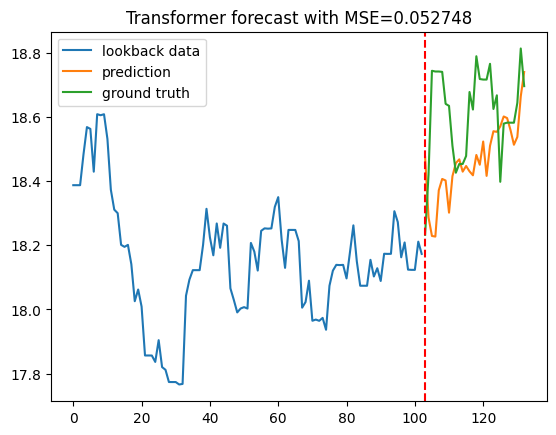

In [88]:
mse = mse_loss(torch.Tensor(prediction), torch.Tensor(ground_truth))
denormalized_data = denormalize(df[-96-7:]["Close"].to_numpy())
num_lookback = denormalized_data.shape[0]

plt.plot(denormalized_data, label="lookback data")
plt.plot(np.concatenate([np.ones(num_lookback) * np.nan, prediction]), label='prediction')
plt.plot(np.concatenate([np.ones(num_lookback) * np.nan, ground_truth]), label='ground truth')
plt.title(f"Transformer forecast with MSE={mse:.6f}")
plt.axvline(x=denormalized_data.shape[0], c='r', linestyle='--')
plt.legend()
plt.show()